In [1]:
import sys
(sys.path).insert(1,'/Users/pedroguicardi/Desktop/CMB_Analysis/MAPSIMS/directories')

import mapsims
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import numpy as np
import healpy as hp
import matplotlib
from matplotlib import pyplot as plt
from pixell import enmap, enplot, reproject, utils, curvedsky
from ad_fns import *
from astropy.io import fits
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from ccat_models import ccat_noise as CCAT_noise
import scipy.optimize as op

In [2]:

NSIDE = 512
lat_lmax = 1500
sim_num = 20
output_file = "sims_output_1"
pysm_string = "d0,s0"


noise = mapsims.SONoiseSimulator(
        nside=NSIDE,
        return_uK_CMB = True,
        sensitivity_mode = "baseline",
        apply_beam_correction = False,
        apply_kludge_correction = False,
        homogeneous=False,
        rolloff_ell = 50,
        ell_max = lat_lmax,
        survey_efficiency = 1.0,
        full_covariance = False,
        LA_years = 5,
        LA_noise_model = "CcatLatv2b",
        elevation = 50,
        SA_years = 5,
        SA_one_over_f_mode = "pessimistic"
    )

def read_sims(sim_num, noise, NSIDE, output_file, pysm_string, apodize=False):
    "output shape will be of the form (bands_#, sim_num , 3, n_pix)"
    chs = ["LC1","LC1","LC2","LC2","LC3"]
    bands = [noise.tubes['LC1'][0].tag, noise.tubes['LC1'][1].tag,noise.tubes['LC2'][0].tag, noise.tubes['LC2'][1].tag,noise.tubes['LC3'][0].tag]
    output = np.zeros((5,sim_num, 3, 12*(NSIDE)**2))
    for j in np.arange(sim_num):
        for k in np.arange(5):
            tmp = hp.fitsfunc.read_map(output_file +"/"+bands[k]+"_" + chs[k]+"_NSIDE_" + str(NSIDE) + "_TAG_" + pysm_string + "_" + str(j) + "_" +".fits", field=(0,1,2))
            if apodize:
                for h in np.arange(tmp.shape[0]):
                    tmp[h,:] = apodize_map(tmp[h,:])
                    
            output[k,j,:,:] = tmp
    return output
    
    
    
sim_data = read_sims(sim_num,noise, NSIDE, output_file, pysm_string, apodize = False)
print(sim_data.shape)
print((sim_data[0,0,0]==sim_data[0,4,0]).all())

(5, 20, 3, 3145728)
False


Compute Power Spectra:

In [3]:
pow_specs = np.zeros((sim_data.shape[0], sim_data.shape[1], 6, lat_lmax+1))
for i in np.arange(sim_data.shape[0]):
    for j in np.arange(sim_data.shape[1]):
        pow_specs[i,j,:,:] = hp.sphtfunc.anafast(sim_data[i,j,:,:], lmax = lat_lmax)
        
avg_spec = np.mean(pow_specs, axis=1)
std_spec = np.std(pow_specs,axis=1)
print(avg_spec.shape, std_spec.shape)

(5, 6, 1501) (5, 6, 1501)


In [14]:
print(pow_specs.shape)
print(pow_specs[0,:,0].shape)

(5, 5, 6, 1501)
(5, 1501)


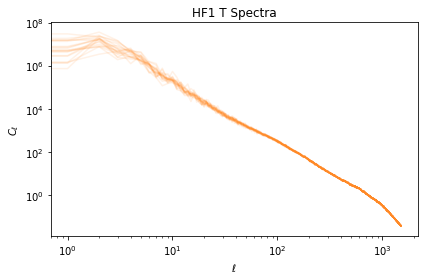

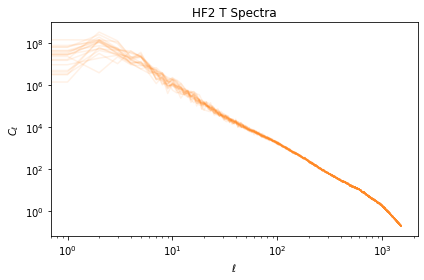

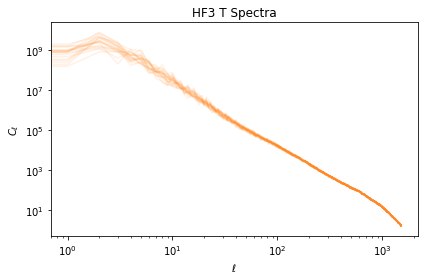

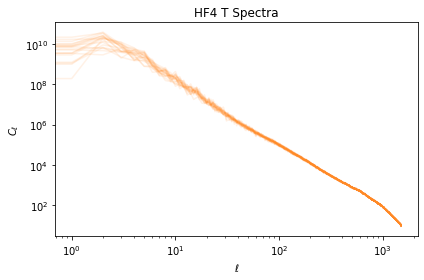

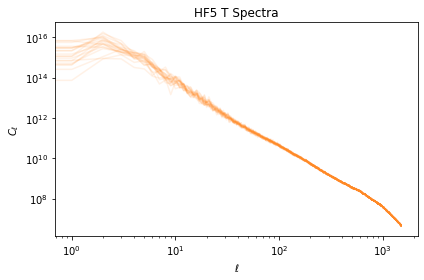

<Figure size 432x288 with 0 Axes>

In [4]:
chs = np.array(["HF1","HF2","HF3","HF4","HF5"])
ell = np.arange(avg_spec.shape[-1])
for i in np.arange(chs.shape[0]):
    for j in np.arange(pow_specs.shape[1]):
        plt.plot(pow_specs[i,j,0], "C1", alpha = 0.1)
    plt.title(chs[i]+" T Spectra")
    plt.xlabel(r'$\ell$')
    plt.ylabel(r'$C_{\ell}$')
    plt.xscale('log')
    plt.yscale('log')
    plt.show()
    plt.clf()

Plot averaged Temperature spectra:

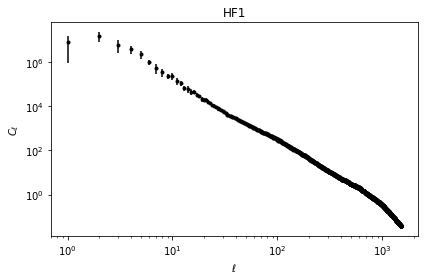

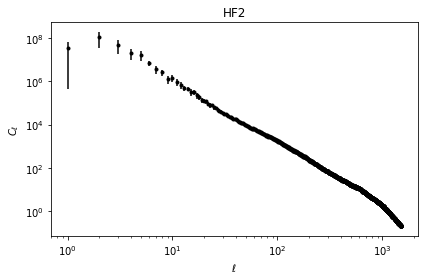

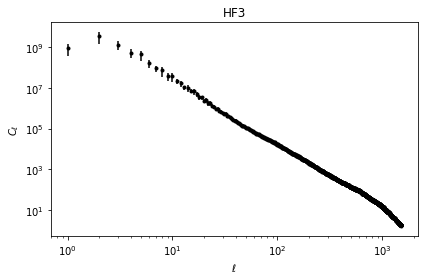

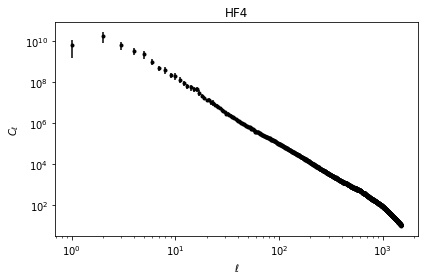

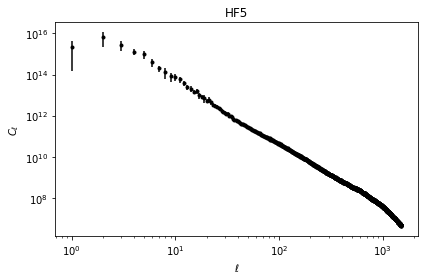

<Figure size 432x288 with 0 Axes>

In [5]:
chs = ["HF1","HF2","HF3","HF4","HF5"]
ell = np.arange(avg_spec.shape[-1])
for i in np.arange(5):
    error = np.std(pow_specs[i,:,0],axis=0)
    plt.errorbar(ell, avg_spec[i,0], yerr=error, fmt=".k", capsize=0)
    plt.title(chs[i])
    plt.xlabel(r'$\ell$')
    plt.ylabel(r'$C_{\ell}$')
    plt.xscale('log')
    plt.yscale('log')
    plt.show()
    plt.clf()

Just testing out fgspectra

[0, 1]
[2, 3]
[4, 4]


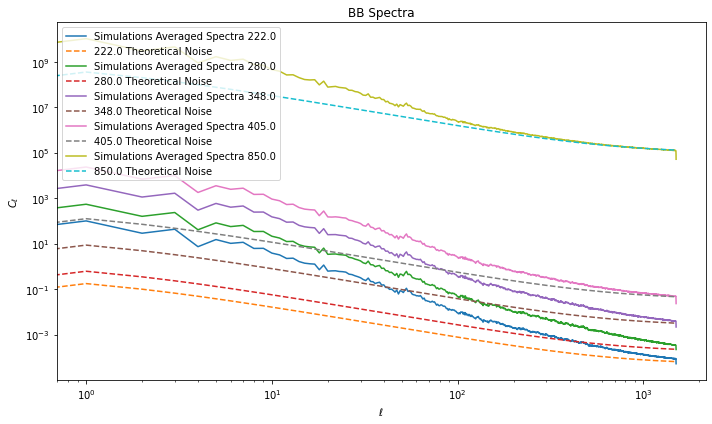

<Figure size 720x432 with 0 Axes>

In [29]:
plt.rcParams["figure.figsize"] = (10,6)
import fgspectra.cross as fgc
from fgspectra.frequency import _rj2cmb

# GET THEORETICAL POWER LAW CROSS SPECTRA for s0,d0
channel_list = [noise.tubes['LC1'][0],noise.tubes['LC1'][1], noise.tubes['LC2'][0],noise.tubes['LC2'][1],noise.tubes['LC3'][0]]

nu = np.array([channel_list[0].center_frequency.value,
               channel_list[1].center_frequency.value, 
               channel_list[2].center_frequency.value,
               channel_list[3].center_frequency.value,
               channel_list[4].center_frequency.value])
dust_params = dict(nu=nu, beta=1.54, temp=20., nu_0=353.)
sync_params = dict(nu=nu, beta=-3., nu_0=23.)
frequency_params = dict(kwseq=(dust_params, sync_params))

power_params = dict(
    ell=np.arange(1500)[1:],
    alpha=np.array([-2.8, -2.4]),  # +2 to (almost) get D_ell
    ell_0=84,
    amp=np.array([0.02 , 0.002])#*(10**0.5)
    ,rho=0.045
)

dust_sync = fgc.CorrelatedDustSynchrotron()

cl = dust_sync(frequency_params, power_params)*4*np.pi**2
conv_factors = np.outer(1/_rj2cmb(nu),1/_rj2cmb(nu)).reshape(len(nu),len(nu),1)
cl= cl*conv_factors


#GET NOISE POWER SPECTRA

def get_noise_cross_spectra(ch_list, noise):
    pspec_matrix = np.zeros((2,3,3,noise.ell_max))
    for i,ch in enumerate(ch_list):
        ell_sim, ps_T, ps_P, fsky, wnoise_power, weightsMap = noise.get_noise_properties(ch)
        pspec_matrix[0,i] = ps_T
        pspec_matrix[1,i] = ps_P
       
    output = np.zeros((5,2,noise.ell_max))
    output[0] = pspec_matrix[:,0,0]
    output[1] = pspec_matrix[:,0,1]
    output[2] = pspec_matrix[:,1,0]
    output[3] = pspec_matrix[:,1,1]
    output[4] = pspec_matrix[:,2,0]
    return output

pspec_matrix= get_noise_cross_spectra(["LC1", "LC2", "LC3"], noise)

#GET CMB AND 

#PLOT
w = get_w(sim_data[0,0,2,:])
for i in np.arange(nu.shape[0]):
#    plt.plot(cl[i,i], linestyle = "--",label = str(nu[i])+ ' Correlated Dust Synch Model fgspectra')
    plt.plot(avg_spec[i,2][1:]/w, label = 'Simulations Averaged Spectra ' +str(nu[i]))
    plt.plot(pspec_matrix[i,1][1:], linestyle = "--",label = str(nu[i])+ ' Theoretical Noise')
    
plt.title('BB Spectra')
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.ylabel(r'$C_{\ell}$')
plt.xlabel(r'$\ell$')
plt.show()
plt.clf()


